In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
from skimage.feature import hog
from skimage import exposure
from skimage import segmentation
from sklearn.cluster import KMeans
from sklearn.model_selection import ShuffleSplit
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import naive_bayes
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn import metrics
from funcionesProyecto import funcionLeerClase, funcionLeerTodasClases, ecualizacionAdaptativa, imagen_media_color, quitarFondo, generarHogClase, generarCsv

In [2]:
lista10c,lista1c,lista1e,lista20c,lista2c,lista2e,lista50c,lista5c = funcionLeerTodasClases('train')

En train/10c, hay 254 ejemplos
En train/1c, hay 77 ejemplos
En train/1e, hay 248 ejemplos
En train/20c, hay 227 ejemplos
En train/2c, hay 25 ejemplos
En train/2e, hay 45 ejemplos
En train/50c, hay 131 ejemplos
En train/5c, hay 284 ejemplos


In [10]:
ejemplos = []
ejemplos.append(lista1c[2])
ejemplos.append(lista2c[0])
ejemplos.append(lista5c[0])
ejemplos.append(lista10c[0])
ejemplos.append(lista20c[0])
ejemplos.append(lista1e[0])
ejemplos.append(lista50c[0])
ejemplos.append(lista2e[0])

ECUALIZACION ADAPTATIVA

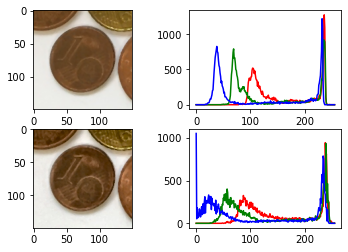

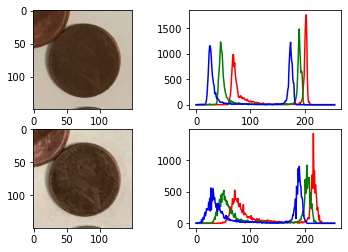

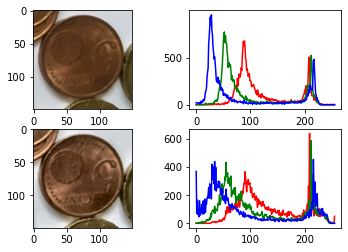

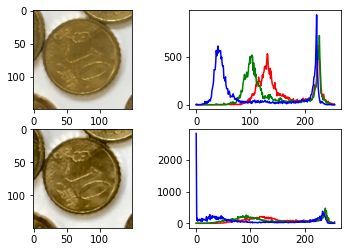

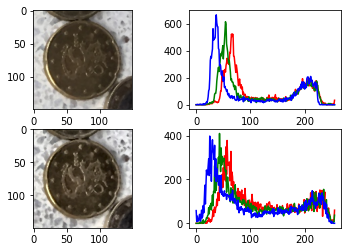

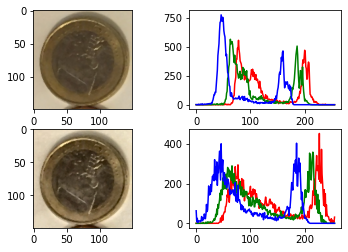

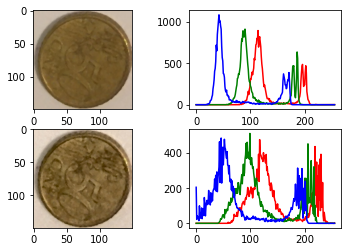

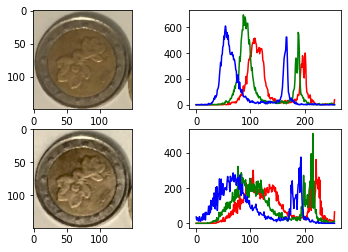

In [11]:
imagenes = lista2e
for img in ejemplos:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist1 = cv2.calcHist([img],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([img],[1],None,[256],[0,256])
    hist3 = cv2.calcHist([img],[2],None,[256],[0,256])
    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.plot(hist1, color = 'red'), plt.plot(hist2, color = 'green'),plt.plot(hist3, color = 'blue')
    imgEcualizada = ecualizacionAdaptativa(img)
    hist1 = cv2.calcHist([imgEcualizada],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([imgEcualizada],[1],None,[256],[0,256])
    hist3 = cv2.calcHist([imgEcualizada],[2],None,[256],[0,256])
    plt.subplot(223), plt.imshow(imgEcualizada) 
    plt.subplot(224), plt.plot(hist1, color = 'red'), plt.plot(hist2, color = 'green'),plt.plot(hist3, color = 'blue')
    plt.show()

QUITAR EL FONDO

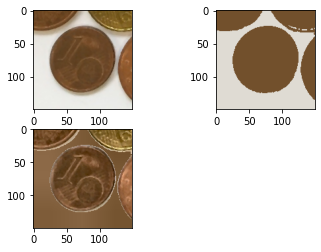

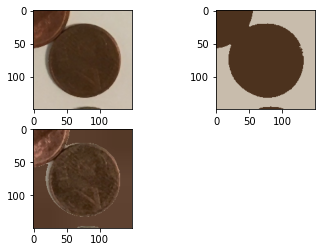

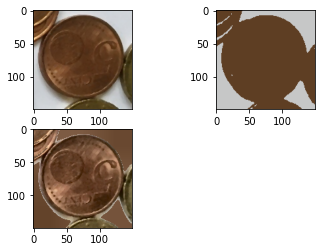

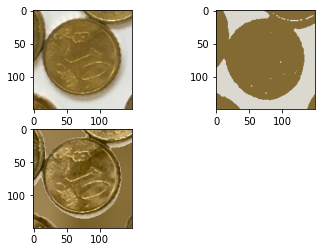

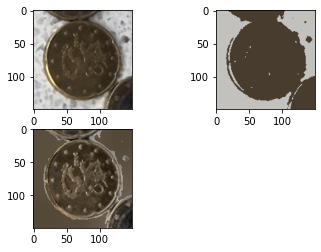

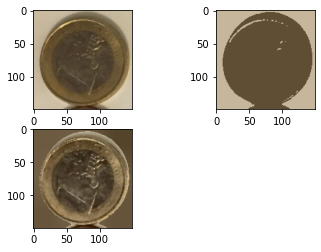

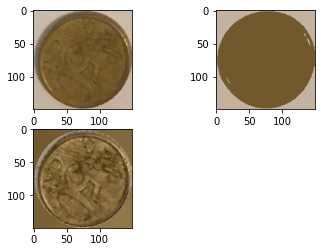

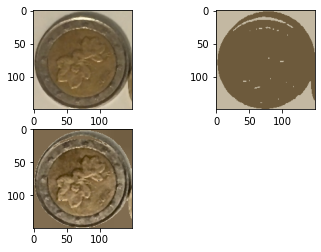

In [14]:
for img in ejemplos:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenMedia, colorMoneda = imagen_media_color(img, 2)
    imagenSinFondo = quitarFondo(img)
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.imshow(imagenMedia,cmap='gray')            
    plt.subplot(223), plt.imshow(imagenSinFondo, cmap = 'gray')
    plt.show()

REALCE BORDES

In [15]:
def realceBordes(imagen, a, tamKernel):    
    imagenConMedia = cv2.blur(imagen,(tamKernel,tamKernel))
    imageBordes = imagen - imagenConMedia
    imagenFinal = (imagen + a * imageBordes).astype(np.uint8)
    return imagenFinal

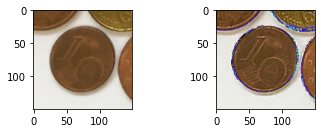

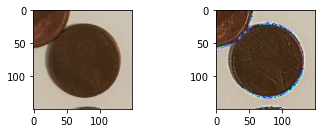

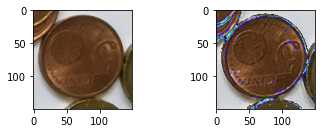

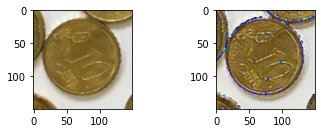

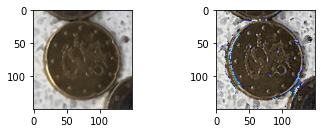

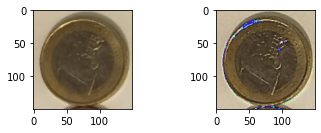

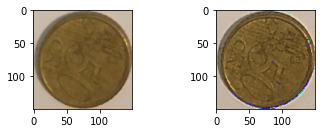

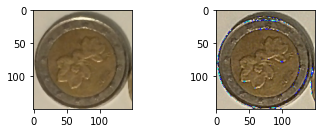

In [16]:
for img in ejemplos:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(221), plt.imshow(img)
    img = realceBordes(img, a = 2, tamKernel = 5)
    plt.subplot(222), plt.imshow(img)            
    plt.show()

MORFOLOGIA MATEMATICA

In [18]:
def umbralAdaptativo(img):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (15, 15), 0)
    thresholded = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 3, 1)
    return thresholded

In [19]:
def umbralGeneral(img):
    gray_blur = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh, imgBinaria = cv2.threshold()

In [20]:
def cerrarHuecos(img):
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=4)
    '''
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=4)'''
    return closing

In [21]:
def detectarCirculos(closing, img):
    nuevaImg = img.copy()
    cont_img = closing.copy()
    contours, hierarchy = cv2.findContours(cont_img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 30:
            continue
        if (len(cnt) < 5):
            continue
        ((x,y), r) = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        cv2.circle(img = nuevaImg, center=center, radius=int(r), color=(0, 255, 0), thickness=1)
    return nuevaImg

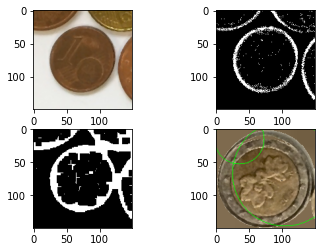

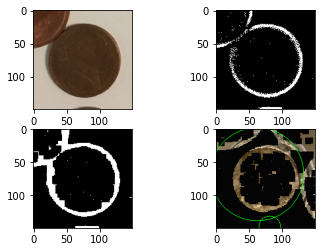

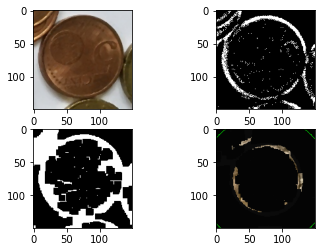

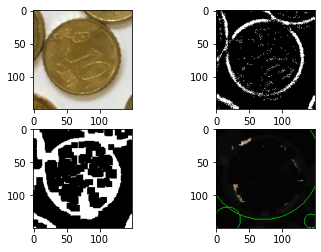

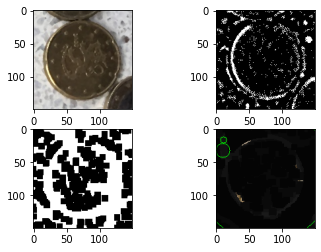

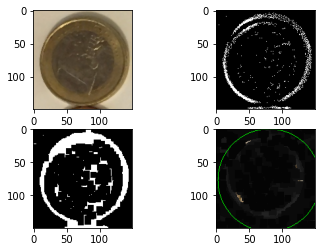

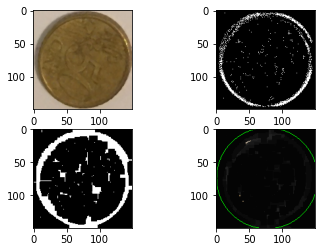

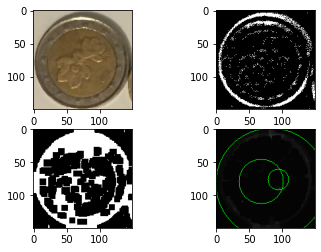

In [23]:
imagenes = lista1c
for img in ejemplos:
    img = cv2.medianBlur(img,3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imagenOriginal = img.copy()
    plt.subplot(221), plt.imshow(img)
    thresholded = umbralAdaptativo(img)
    plt.subplot(222), plt.imshow(thresholded,cmap='gray')
    closing = cerrarHuecos(thresholded)
    plt.subplot(223), plt.imshow(closing, cmap = 'gray')
    conCirculos = detectarCirculos(closing, imagenSinFondo)
    plt.subplot(224), plt.imshow(conCirculos, cmap = 'gray')
    grayOutput = cv2.cvtColor(conCirculos, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(imagenOriginal, cv2.COLOR_RGB2GRAY)
    siluetaMoneda = gray-grayOutput
    mascaraMoneda = np.copy(siluetaMoneda)
    cnts = cv2.findContours(mascaraMoneda, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cv2.fillPoly(mascaraMoneda, cnts, (255, 255, 255))
    imagenSinFondo[closing==0] = 0
    imagenSinFondo = ecualizacionAdaptativa(imagenSinFondo)
    plt.show()